# Introduction/ Welcome word.

Hi! 

In this project I focused on conducting **statistical inference with Python** and strengthening SQL and Data Visualisation skills. It also included first touches to **Google Looker Studio**.

For this purpose I worked with a Podcast Reviews Dataset, which has a SQLite database of over 2e6 Podcast Reviews. [Link to the Dataset](https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28)

<span style="font-size: larger;">**Project Problem:**</span>

Sports have consistently taken a prominent spot in news coverage and other media. This prominence extends to sports podcasts as well. Despite the increasing number of podcasts being released, concerns persist regarding the quality, particularly when comparing podcasts from different subcategories.

<span style="font-size: larger;">**Proposed Solution:**</span>

I propose addressing this issue by utilizing data analysis and statistical inference techniques. My objective is to examine podcast reviews across specific sports categories. Through this analysis, I aim to uncover valuable insights and draw conclusions regarding significant variations in both the quality and quantity of podcasts within these categories.



# Project approach/ objectives.

My approach to this project follows a structured, step-by-step methodology grounded in
data science best practices. Each stage is thoughtfully designed to build upon the previous,
ensuring a cohesive and comprehensive solution:

1. **Understand the Data.**  The first step involves a thorough understanding of the dataset, its
variables, and its structure. This step is crucial for shaping the subsequent stages of the project.


2. **Data Preprocessing.**  After understanding the dataset, we clean and preprocess the data.


3. **Exploratory Data Analysis.** With selected features (based on domain knowledge and how they fit) this stage covers unearthing patterns, spotting anomalies, checking assumptions through visual and quantitative methods. It provides an in-depth understanding of the variables and their interrelationships.


4. **Hypothesis testing.** After Data Analysis is completed, most interesting patterns will be thoroughly investigated using stastitical inference approach.


5. **Presentation of dashboard.** This includes Google Looker Studio dashboard for the Sports Podcast performance review for the year of 2022.

# Standards and Assumptions.

1. Text of Podcasts Reviews will not be analyzed using any NLP packages/ techniques. This project focuses solely on Statistical Inference, on writing quality SQL queries and creating visualy appealing visualizations.


2. Google Looker Studio Dashboard will be presented after the Jupyter Notebook presentation. This focuses solely on selected categories of podcasts for the desired year.


3. The idea that Capital Letters and Special Characters might indicate frustration in the review content is a personal assumption, and it's just an opinion that stems from personal knowledge. This viewpoint is open for discussion. If statistical significance or trend will be found this could be a potential variable for the classical machine learning alhorithm that classifies sentiments (Random Forest Classifier, Logistical Regression or etc.)


4. In this project I did not touch a 'sports' category, instead I focused on more specific ones. Although I understand that sports category can contain 'bastkeball' podcasts, this will not be investigated and I will believe that all relevant information lies within subcategories.


5. T-Tests (which will be conducted) rely on assumption of normal distribution for the sample. However due to large sample size, I will rely on CLT and ignore this assumption.


6. Instead of giving a lot of attention to date feature, I decided to take a different look and focused on how to prepare this data for other steps (like ML modelling).

# Data Preprocessing.

This section involves:
* **Data Collection** (Importing necessary libraries, retrieving the dataset, reading the dataset in the Pandas DataFrame);
* **Data Understanding** (descriptive statistics, purpose of different features);
* **Data Cleaning.**

## Data Collection.

In [51]:
# Importing all necessary libraries and packages;
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats.distributions as dist
import researchpy
import warnings
import plotly.express as px
from scipy import stats
from functools import reduce
from pivottablejs import pivot_ui
import re
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [43]:
con = sqlite3.connect('./database.sqlite')

The SQLite Dataset **contains 4 tables** - Reviews, Categories, Podcasts and Runs.

Although information from **Runs table will not be used for this project** (it displays information about when which podcast reviews had been added to the Dataset, so it does not provide any added value).

In [44]:
podcasts = pd.read_sql("SELECT * FROM podcasts", con)
reviews = pd.read_sql("SELECT * FROM reviews", con)
categories = pd.read_sql("SELECT * FROM categories", con)

In [45]:
podcasts.head(2)

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando


In [6]:
podcasts.podcast_id.nunique()

110024

In [7]:
podcasts.title.nunique()

109274

**It turns out there are reviews of 110 024 unique podcasts. Although I will have to keep in mind that around 900 podcasts have overlapping names. Most popular are displayed below.**

In [8]:
podcasts.title.value_counts().head(5)

No Title              8
Guided Meditations    4
Welcome Home          4
Office Hours          4
What's Next?          4
Name: title, dtype: int64

Let's proceed with another tables.

In [10]:
categories.head(1)

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts


In [11]:
categories.shape

(212372, 2)

In [12]:
reviews.head(1)

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00


In [13]:
reviews.podcast_id.value_counts().head()

bf5bf76d5b6ffbf9a31bba4480383b7f    33104
bc5ddad3898e0973eb541577d1df8004    10675
bad6c91efdbee814db985c7a65199604     9698
f5fce0325ac6a4bf5e191d6608b95797     8248
f2377a9b0d9a2e0fb05c3dad55759328     7389
Name: podcast_id, dtype: int64

In [14]:
reviews.shape

(2067529, 6)

**Indeed there are over 2 million reviews and some podcasts have been reviewed more than 33k times. Also it turns out that some of the podcasts are assigned to more than one category.**

## Data Understanding.

To fully understand the data I will be working with, first I will query it into a dataset that will be used for future analysis.

**Important Note**: 

There's slightly over 2 million reviews and 100k+ unique podcasts, so to have adequate representation of the situation, I will additionally create two columns - **Mean Podcast Rating** and **Times Reviewed**.

In [46]:
# Query average ratings and how many times a podcast had been reviewed;
total_reviews = pd.read_sql_query('''
SELECT  r.podcast_id AS podcast_id,
        p.title AS podcast_title,
        COUNT(*) AS times_reviewed,
        AVG(r.rating) AS mean_rating
FROM reviews r
JOIN podcasts p
ON p.podcast_id = r.podcast_id
GROUP BY r.podcast_id, p.title
''', con)

**Let's take a look at how distributed are podcast reviews across mean ratings.**

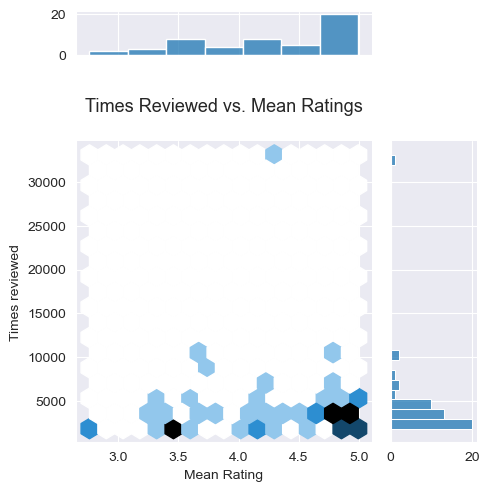

In [47]:
# Code
most_views = total_reviews.nlargest(50, 'times_reviewed')
sns.jointplot(data=most_views, x='mean_rating', y='times_reviewed', kind='hex', height=5, ratio=3, marginal_ticks=True, palette="gist_earth")
plt.xlabel("Mean Rating")
plt.ylabel("Times reviewed")
plt.title("\nTimes Reviewed vs. Mean Ratings\n", fontsize=13)
plt.tight_layout()

**Couple of things can already be concluded:**
1. Majority of podcasts were rated as 5;
2. Majority of podcasts have been reviewed less than 10 000 times;
3. Most common podcasts are of two major types:
    * Has less than 5k reviews and mean rating is above 4.5. 
    * Has mean rating of around 3.5 and less than 5k reviews.
4. A podcast with slightly over 30k reviews is a clear outlier.

Now let's take a look, which podcasts were the most popular (reviewed most times) and how they perform rating wise.

In [59]:
# Code

most_popular_sorted = most_views.sort_values(by='times_reviewed', ascending=False).head(10)

fig = px.bar(
    most_popular_sorted,
    x='mean_rating',
    y='podcast_title',
    color='times_reviewed',
    orientation='h',
    color_continuous_scale='Cividis',
    title='TOP Podcasts by Mean Rating and Times Reviewed',
    labels={'mean_rating': 'Mean Rating', 'times_reviewed': 'Times Reviewed', 'podcast_title' : ''}
)

fig.show();

**Couple of things can be concluded:**
1. Ratings for the most reviewed podcasts tend to me lower;
2. Crime Junkie is the most popular podcast (has the most reviews);

In [22]:
reviews.rating.value_counts()

5    1790057
1     116547
4      62883
3      52176
2      45866
Name: rating, dtype: int64

**Almost 87 % of the reviews are 5. And 5 % are 4.**

It means that only 8 % of podcasts are rated as 3 or lower.

**Now let's take a look at the different sport categories.**

In [23]:
# Code
a = categories.category.value_counts()
for b, c in a.items():
    if 'sports' in b:
        print(b, c)

sports 8388
sports-football 969
news-sports-news 747
sports-basketball 722
sports-wilderness 603
sports-fantasy-sports 482
sports-soccer 454
sports-baseball 443
sports-wrestling 418
sports-hockey 259
sports-golf 169
sports-running 153
sports-tennis 38
sports-rugby 35
sports-cricket 21
sports-swimming 18
sports-volleyball 14


Since sports category contains all kind of sports, for further analysis **only** basketball, soccer and running (personal preference) will only be used.

In [24]:
# Query all podcast reviews that are of required categories.
sports = pd.read_sql_query('''
SELECT  r.podcast_id AS podcast_id, 
        c.category AS category,
        p.title AS podcast_title,
        r.title AS review_title,
        r.content AS content,
        r.rating AS rating,
        r.created_at AS created_at
FROM reviews r
JOIN categories c
ON c.podcast_id = r.podcast_id
JOIN podcasts p
ON p.podcast_id = c.podcast_id
WHERE c.category IN ('sports-soccer', 'sports-running', 'sports-basketball');
''', con)

In [25]:
sports.head(2)

,podcast_id,category,podcast_title,review_title,content,rating,created_at
0,e796ca5d5d00ae8516301a63e906b3a5,sports-soccer,No Question About That - Manchester United pod...,CALYPSO!!!!,Best United pod in the world. Been listening s...,5,2016-08-12T16:29:46-07:00
1,e796ca5d5d00ae8516301a63e906b3a5,sports-soccer,No Question About That - Manchester United pod...,Wayne Rooney Fan Show,Just kidding about the title. Paul and Ed do a...,5,2015-05-19T18:49:13-07:00


In [26]:
sports.shape

(29818, 7)

**Let's take a look at the reviews per podcast ratio:**

In [27]:
# Code
basketball_count = len(sports[sports['category'] == 'sports-basketball']) // 722
soccer_count = len(sports[sports['category'] == 'sports-soccer']) // 454
running_count = len(sports[sports['category'] == 'sports-running']) // 153

text = (
    f"Reviews per podcast: Basketball: {basketball_count}, "
    f"Soccer: {soccer_count}, Running: {running_count}")

print(text)

Reviews per podcast: Basketball: 24, Soccer: 12, Running: 40


**While review per podcast ratio is unequal, no further aggregation will be done, because representing a mean of different means make even less sense**.

## Data Cleaning.

With the consistent dataset now it's time to do the data cleaning. First I will make 'category' column more readable.

In [28]:
mappings = {'sports-basketball': 'basketball',
            'sports-running': 'running',
            'sports-soccer': 'soccer'}

sports['category'] = sports['category'].replace(mappings)

Now let's deal with the date column. For me, year of the podcast review is more than enough.

In [29]:
# sports['created_at'] = sports['created_at'].str[:4]
sports['created_at'] = sports['created_at'].astype(int)

In [30]:
sports.isna().sum()

podcast_id       0
category         0
podcast_title    0
review_title     0
content          0
rating           0
created_at       0
dtype: int64

In [33]:
sports.duplicated().sum()

0

In [32]:
sports = sports.drop_duplicates()

**There are no missing values or duplicated rows in the dataset**.

In [34]:
sports.describe(include='all')

,podcast_id,category,podcast_title,review_title,content,rating,created_at
count,29771,29771,29771,29771,29771,29771.000000,29771.000000
unique,1326,3,1322,21463,29697,NaN,NaN
top,d18048f07e38e2a022c07b4638439321,basketball,Locked On Lakers - Daily Podcast On The Los An...,Great podcast,"It is crazy that at the start of every game, R...",NaN,NaN
freq,1507,17991,1507,327,5,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,4.688522,2019.398710
std,NaN,NaN,NaN,NaN,NaN,0.967748,2.054868
min,NaN,NaN,NaN,NaN,NaN,1.000000,2006.000000
25%,NaN,NaN,NaN,NaN,NaN,5.000000,2018.000000
50%,NaN,NaN,NaN,NaN,NaN,5.000000,2020.000000
75%,NaN,NaN,NaN,NaN,NaN,5.000000,2021.000000


**Couple of remarks:**

* Since there are no duplicated values, it's worth investigating why, content is repetitive in some reviews.
* Basketball reviews are dominant in this dataset.
* Mean rating is 4.68, while standard deviation is almost 1.
* There is almost 1.5 k unique podcasts in this Dataset.
* Earliest podcast review has been done in 2006, while newest ones are performed this year. Most of the reviews are centered around mean year (2019).

In [136]:
sports[sports['content'] == 'It is crazy that at the start of every game, Rachel Nichols flashes the white power symbol with her left hand, for a long time during her monologue. You can go back and check. She did it from the preseason on. She obviously does not Want to be around “those” people. It devastated  my children and I when we saw it. It is awful to do to the young, full of hopes and dreams.\n    It is clear she wants to do something else. Let her do that something else away from our sons and daughters.']

,podcast_id,category,podcast_title,review_title,content,rating
12333,d4739f40eae569ab79c623ca3fb0508f,basketball,Locked On NBA – Daily Podcast On The National ...,Rachel Nichols,"It is crazy that at the start of every game, R...",5
12337,ce01126b8502ccb7a8075310ff9be831,basketball,Open Floor: SI's NBA Show,Rachel Nichols,"It is crazy that at the start of every game, R...",5
12346,c1a9f9aec4a10b08e74f04995207a46e,basketball,The No Chill with Gilbert Arenas Podcast,Rachel Nichols,"It is crazy that at the start of every game, R...",5
20645,d6607ad9e2bcc9c7fc85f361da0deded,basketball,Locked On Bucks – Daily Podcast On The Milwauk...,Rachel Nichols,"It is crazy that at the start of every game, R...",5
24922,f4e25f3426c53723d87bb0b552781cc6,basketball,The Lakers Legacy Podcast,Rachel Nicols,"It is crazy that at the start of every game, R...",5


**It seems that there's nothing wrong with the data. It is more likely that there is bias why it happened (e.g. frustration, bot or etc.)**

# Data analysis and Hypothesis testing.

## Data Analysis.

Let's take a look at the main characteristics of the dataset.

At first I will take a look at countplots of each category (basketball, soccer, running).

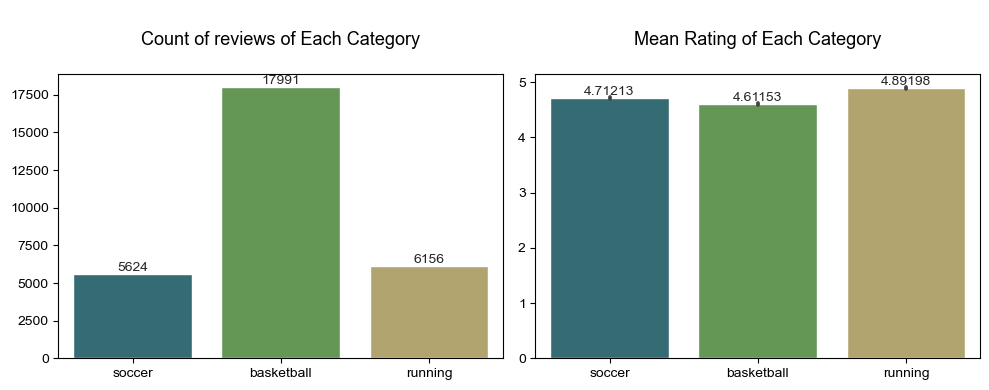

In [35]:
# Code
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.set_style("darkgrid")

sns.countplot(x="category", data=sports, ax=ax[0], palette="gist_earth")
ax[0].set_title("\nCount of reviews of Each Category\n", fontsize=13)
ax[0].set(ylabel="", xlabel="")
ax[0].bar_label(ax[0].containers[0])

sns.barplot(data= sports, x="category", y='rating', ax=ax[1], palette="gist_earth")
ax[1].set_title("\nMean Rating of Each Category\n", fontsize=13)
ax[1].set(ylabel="", xlabel="")
ax[1].bar_label(ax[1].containers[0])

plt.tight_layout()
plt.show()

**Couple of things can be concluded:**
1. Basketball podcasts are a lot more reviewed;
2. Running podcasts tend to have higher Mean Rating;
3. Although there are more soccer podcasts, running podcasts tend to have more reviews.

**Let's use some aggregation methods to check for more descriptive statistics.**

In [186]:
pd.set_option("display.expand_frame_repr", False)
statistics = sports.groupby("category")["rating"].describe()
print(statistics)

              count      mean       std  min  25%  50%  75%  max
category                                                        
basketball  17991.0  4.611528  1.074593  1.0  5.0  5.0  5.0  5.0
running      6156.0  4.891975  0.555186  1.0  5.0  5.0  5.0  5.0
soccer       5624.0  4.712127  0.928239  1.0  5.0  5.0  5.0  5.0


**Couple of additional things that can be concluded:**
1. Running seem to have the lowest variability of ratings across different categories, while basketball has the highest.
2. All categories seem to have over 3/4 of their ratings to be 5.

<Figure size 1400x500 with 0 Axes>

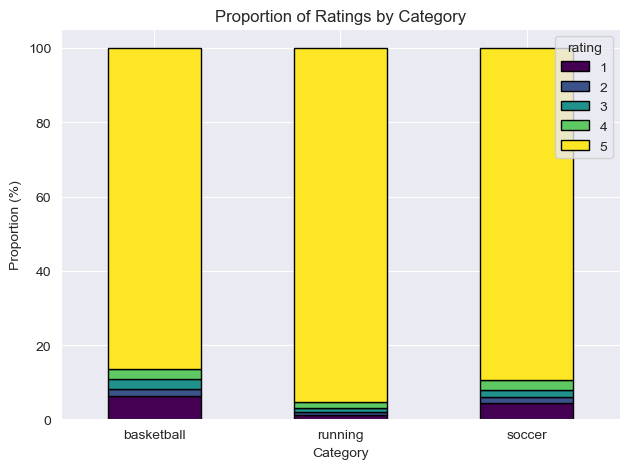

In [41]:
# Code
plt.figure(figsize=(14, 5))
rating_dist = pd.crosstab(sports["category"], sports["rating"], normalize="index") * 100
rating_dist.plot(kind="bar", stacked=True, edgecolor="black", colormap="viridis")
plt.xlabel("Category")
plt.xticks(rotation=0)
plt.ylabel("Proportion (%)")
plt.title("Proportion of Ratings by Category")
plt.tight_layout()
plt.show();

**Now let's take a closer look at the numbers for how many times podcast was reviewed**.

In [189]:
grouped = sports.groupby("category")["podcast_id"]
statistics = grouped.value_counts().groupby("category").describe()
print(statistics)

            count       mean         std  min  25%  50%    75%     max
category                                                              
basketball  722.0  24.918283   88.281750  1.0  2.0  4.0  14.00  1507.0
running     153.0  40.235294  128.531778  1.0  1.0  5.0  23.00  1273.0
soccer      454.0  12.387665   44.957418  1.0  1.0  2.0   6.75   670.0


**Couple of things can be concluded:**
1. Soccer podcasts seem to be a lot less reviewed, although they are produced at similar rates to basketball.
2. There seems to be high variability in review numbers, what is suggested by standard deviation of all different categories. Some podcasts are a lot better than the others.

**Now let's take a look at the rating distribution across categories through the years.**

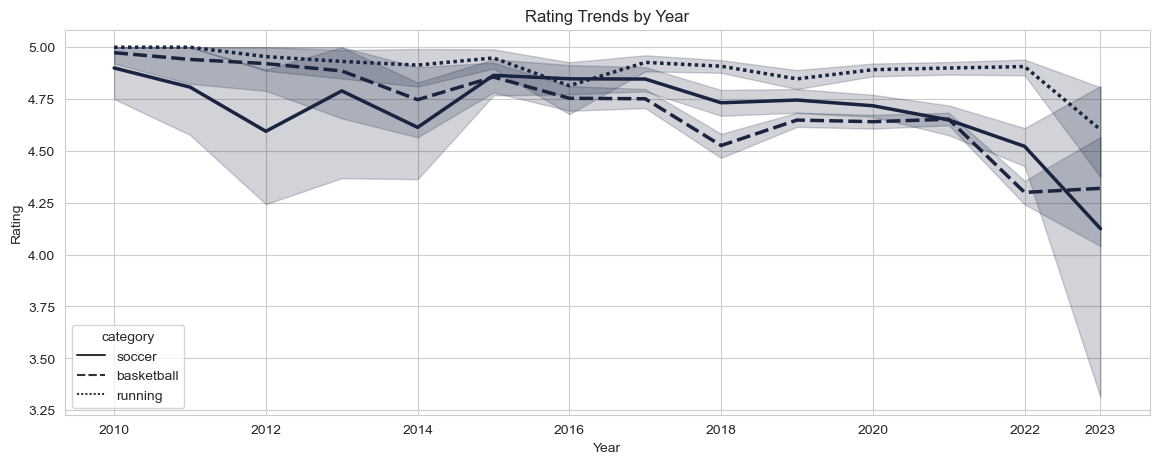

In [289]:
# Code
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))
sns.lineplot(data=sports[sports['created_at'] >= 2010], x='created_at', style='category', y='rating', palette='gist_earth', linewidth=2.5)
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Rating Trends by Year")
custom_xticks = [2010, 2012, 2014, 2016, 2018, 2020, 2022, 2023]
plt.xticks(custom_xticks)
plt.show()

**Couple of things can be concluded:**
1. Running podcasts seem to have relatively stable rating projection over the years.
2. Basketball and soccer podcast mean ratings are at constant competition and also they faced severe downgrade in mean ratings starting from 2021.

**Overall, dataset seem to be very interesing to analyze with many different trends and patterns still unearthed. This leads to ideas for hypothesis testing, to make valid statistical inference on this aspect**.

In [297]:
basketball_data = sports[sports['category'] == 'basketball']
soccer_data = sports[sports['category'] == 'soccer']
running_data = sports[sports['category'] == 'running']

## Hypothesis testing.

Hypothesis testing is a critical tool in determining what statistical inference could be.

For this I will use theoretical approach with two main attributes:
    
**Null Hypothesis: $H_0$**

**Alternative Hypothesis: $H_a$**


### Comparison of means for three samples.

First step is to identify, whether there are any significant differences in the means of all three categories. For this, ANOVA (Analysis of variance) test will be performed.

**Research Question:**
Considering ratings in the podcasts reviews data, did basketball, running, soccer podcasts rating differ significantly?

**Population**: Basketball, Running, Soccer podcasts in the Podcast Reviews Data.  

**Null Hypothesis:** $\mu_1 = \mu_2$ = $\mu_3$.

**Alternative Hypthosis:** At least one group mean is different from the others. E. g.: $\mu_1 \neq \mu_2$

In [335]:
result = stats.f_oneway(running_data['rating'], basketball_data['rating'], soccer_data['rating'])

print("ANOVA Result:", result)

ANOVA Result: F_onewayResult(statistic=197.22089111319653, pvalue=8.138766388065443e-86)


**Observed very low p value indicates strong evidence against the null hypothesis. It means that at least one of the groups have significantly different ratings, thus we can proceed with comparisons of means between two samples**.

### Comparison of means for two samples.

**1st Research Question:**
Considering ratings in the podcasts reviews data, did basketball podcasts have significantly lower ratings than the soccer podcasts?

**Population**: Basketball and Soccer podcasts in the Podcast Reviews Data.  
**Parameter of Interest**: $\mu_1 - \mu_2$, Rating.  
**Null Hypothesis:** $\mu_1 = \mu_2$  
**Alternative Hypthosis:** $\mu_1 < \mu_2$

In [332]:
# Calculating differences in means, t test statistics and confidence intervals.
diff = basketball_data["rating"].mean() - soccer_data["rating"].mean()

confidence_level = 0.95

result = stats.ttest_ind(basketball_data["rating"], soccer_data["rating"], alternative='less', equal_var=True)

degrees_of_freedom = len(basketball_data["rating"]) + len(soccer_data["rating"]) - 2

conf_interval = stats.t.interval(confidence_level, degrees_of_freedom, loc=np.mean(basketball_data["rating"]) - np.mean(soccer_data["rating"]), scale=np.sqrt((np.var(basketball_data["rating"], ddof=1) / len(basketball_data["rating"])) + (np.var(soccer_data["rating"], ddof=1) / len(soccer_data["rating"]))))

print("Difference in two means: ", diff, "\n\nResult of t-test:\n\n", result, "\n\n Confidence Interval:\n\n", conf_interval)

Difference in two means:  -0.10059861406916504 

Result of t-test:

 Ttest_indResult(statistic=-6.321842288013412, pvalue=1.3154305681847192e-10) 

 Confidence Interval:

 (-0.12949812959937082, -0.07169909853895926)


**Since our observed p value is nearly 0, we can reject null hypothesis and with 95 % confidence infer than basketball podcasts have significantly lower mean rating than soccer podcasts across podcast reviews**.

**2nd Research Question:**
Considering ratings in the podcasts reviews data, did running podcasts have significantly higher ratings than the soccer podcasts?

**Population**: Running and Soccer podcasts in the Podcast Reviews Data.  
**Parameter of Interest**: $\mu_1 - \mu_2$, Rating.  
**Null Hypothesis:** $\mu_1 = \mu_2$  
**Alternative Hypthosis:** $\mu_1 > \mu_2$

In [333]:
# Calculating differences in means, t test statistics and confidence intervals.

diff = running_data["rating"].mean() - soccer_data["rating"].mean()

confidence_level = 0.95

result = stats.ttest_ind(running_data["rating"], soccer_data["rating"], alternative='greater', equal_var=True)

degrees_of_freedom = len(running_data["rating"]) + len(soccer_data["rating"]) - 2

conf_interval = stats.t.interval(confidence_level, degrees_of_freedom, loc=np.mean(running_data["rating"]) - np.mean(soccer_data["rating"]), scale=np.sqrt((np.var(running_data["rating"], ddof=1) / len(running_data["rating"])) + (np.var(soccer_data["rating"], ddof=1) / len(soccer_data["rating"]))))

print("Difference in two means: ", diff, "\n\nResult of t-test:\n\n", result, "\n\n Confidence Interval:\n\n", conf_interval)

Difference in two means:  0.1798487083574809 

Result of t-test:

 Ttest_indResult(statistic=12.886795324231006, pvalue=4.803480165928642e-38) 

 Confidence Interval:

 (0.15190170068842118, 0.20779571602654062)


**Since our observed p value is nearly 0, we can reject null hypothesis and with 95 % confidence infer than running podcasts have significantly higher mean rating than soccer podcasts across podcast reviews.**

## Special Cases.

Since we still have a content of a review in our DataFrame it would be interesting to analyze a little fraction for it to test hypothesis. 

Internet slang often implies that a message with an **abundance of capital letters is likely to convey a negative tone.**

The same can go with specials **(!? and etc)**. 

In this case we will take a look at our category data to test some hypothesis.

In [37]:
sports['capital_proportion'] = sports['content'].apply(lambda x: len(re.findall('[A-Z]', x)) / len(x) if len(x) > 0 else 0)
sports['count_specials'] = sports['content'].apply(lambda x: len(re.findall('[^a-zA-Z0-9]', x)))

### Mean capital letter proportion in the review content.

First lets take a look at the aggregated pivot table to understand the trend.

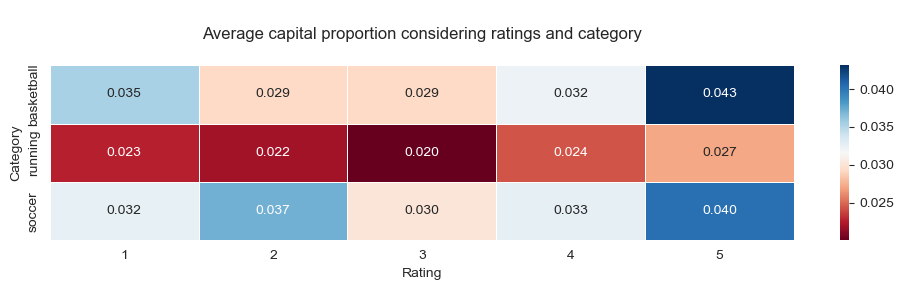

In [38]:
# Code
pivot_table = sports.pivot_table(
    index=sports['category'],
    columns="rating",
    values="capital_proportion",
    aggfunc="mean",
)

pivot_table

plt.figure(figsize=(10, 3))
sns.heatmap(pivot_table, annot=True, cmap="RdBu", fmt=".3f", linewidths=0.5)
plt.title("\nAverage capital proportion considering ratings and category\n")
plt.xlabel("Rating")
plt.ylabel("Category")

plt.tight_layout()
plt.show()

**It can be noted, that best rated (running) podcasts tend to have stable capital letter proportion numbers and tend to have lower capital letter proportion than running or soccer.**

**Research Question:**
Considering average capital propotion in the podcasts reviews, did running podcasts have significantly lower average capital letter proportion than the soccer podcasts?

**Population**: Running and Soccer podcast reviews in the Podcast Reviews Data.  
**Parameter of Interest**: $\mu_1 - \mu_2$, Average Capital Letter proportion.  
**Null Hypothesis:** $\mu_1 = \mu_2$  
**Alternative Hypthosis:** $\mu_1 < \mu_2$

In [394]:
# Code
running_data = sports[sports['category'] == 'running']
soccer_data = sports[sports['category'] == 'soccer']

result = ttest_ind(running_data['capital_proportion'], soccer_data['capital_proportion'], alternative='less')

print("Result of two-sample t-test:")
print("Statistic:", result.statistic)
print("P-value:", result.pvalue)

Result of two-sample t-test:
Statistic: -20.453415064458255
P-value: 1.073795597908101e-91


**P-value is extremely low, so it means we can reject Null hypothesis and with 95 % confidence infer that running podcast reviews have lower capital letter proportion. However, we cannot prelude that higher ratings are associated with lower capital proportion, because trend seem to go opposite.**

### Mean special character proportion in the review content.

First lets take a look at the aggregated pivot table to understand the trend.

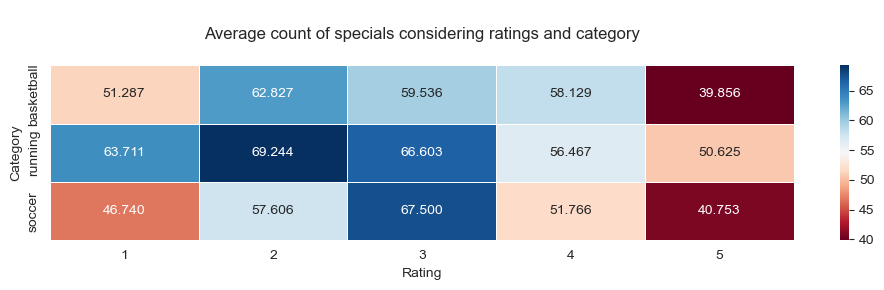

In [391]:
# Code
pivot_table2 = sports.pivot_table(
    index=sports['category'],
    columns="rating",
    values="count_specials",
    aggfunc="mean",
)

pivot_table

plt.figure(figsize=(10, 3))
sns.heatmap(pivot_table2, annot=True, cmap="RdBu", fmt=".3f", linewidths=0.5)
plt.title("\nAverage count of specials considering ratings and category\n")
plt.xlabel("Rating")
plt.ylabel("Category")

plt.tight_layout()
plt.show()

It could be noted, that lowest values for special characters are observed at higher ratings, so we can assume that lower rated podcasts have more special characters in their review content. Let's try to prove it by dividing into bad rating(1-3) and good (4-5).

**Research Question:**
Considering number of special characters in the podcasts reviews, did better rated podcasts had lower count of special characters than poorly rated podcasts?

**Population**: Running, Soccer, Basketball podcast reviews in the Podcast Reviews Data.  
**Parameter of Interest**: $\mu_1 - \mu_2$, Mean count of special characters.  
**Null Hypothesis:** $\mu_1 = \mu_2$  
**Alternative Hypthosis:** $\mu_1 < \mu_2$

In [399]:
# Code
bad_ratings_data = sports[(sports['rating'] >= 1) & (sports['rating'] <= 3)]
good_ratings_data = sports[(sports['rating'] >= 4) & (sports['rating'] <= 5)]

proportion_bad = bad_ratings_data['count_specials']
proportion_good = good_ratings_data['count_specials']

result = stats.ttest_ind(proportion_good, proportion_bad, alternative='less')

print("Result of two-sample t-test:")
print("Statistic:", result.statistic)
print("P-value:", result.pvalue)

Result of two-sample t-test:
Statistic: -14.550227908934701
P-value: 4.24808763312212e-48


**Result provides strong evidence that podcasts with good ratings tend to have a lower mean proportion of special characters in their reviews compared to podcasts with bad ratings**.

# Google Looker Studio Dashboard.

[Link to the Dashboard](https://lookerstudio.google.com/reporting/497639c0-b7c8-4d88-a1e6-21323f6e8b18/page/0wUaD)

# Areas for improvement.

1. For the next opportunity, such as a Capstone project, consider delving deeper into a specific area of interest, like focusing exclusively on running podcasts.

2. Try Polars package (for better computation speeds).

3. Use NLP packagages for review content analysis.

# General Conclusions.

**Whole dataset:**

1. The podcasts that appear most frequently in the dataset typically receive fewer than 5000 total reviews, with an average rating around 3.5 and above 4.5.
2. Crime Junkie stands out as the most popular podcast, and interestingly, there's a trend where podcasts with the highest number of views tend to have lower ratings.


**For the area of interest:**

1. On average each basketball, soccer, running podcast is reviewed 24, 12, 40 times respectively.
2. 60% of podcast (considering only basketball, soccer, running) reviews are about basketball.
3. Running podcasts are more and better reviewed/ rated than others.
4. In all categories, a minimum of 75% of ratings are scored as 5.
5. Ratings for running podcasts display the least variability among all categories, often indicating higher quality content.
6. While soccer podcasts are produced at a similar rate to basketball podcasts, they tend to receive significantly fewer reviews.
7. There is a high variability in total review numbers, what indicates that some podcasts are a lot better than the other.
8. Mean ratings deteriorated for all categories starting from 2021.
9.  Basketball podcasts (within this dataset) have significantly lower mean ratings than soccer podcasts.
10. Running podcasts (within this dataset) have significantly higher mean ratings than soccer podcasts.
11. Podcasts with good ratings tend to have a lower proportion of special characters in their reviews compared to podcasts with bad ratings.

<img src="https://t3.ftcdn.net/jpg/02/91/52/22/240_F_291522205_XkrmS421FjSGTMRdTrqFZPxDY19VxpmL.jpg" alt="study" width="400">
